In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import sklearn
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_modelo_inicio = pd.read_pickle("df_alunos_escolas_modelo_pickle")

In [3]:
len(df_modelo_inicio)

1330325

In [4]:
list(df_modelo_inicio)

['NU_INSCRICAO',
 'NU_IDADE',
 'TP_SEXO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'TP_ST_CONCLUSAO',
 'TP_ENSINO',
 'CO_MUNICIPIO_RESIDENCIA',
 'CO_MUNICIPIO_ESC',
 'SG_UF_ESC_x',
 'TP_DEPENDENCIA_ADM_ESC_x',
 'TP_LOCALIZACAO_ESC_x',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_OUTRA_DEF',
 'CO_MUNICIPIO_PROVA',
 'Q001',
 'Q002',
 'Q003',
 'Q004',
 'Q005',
 'Q007',
 'Q008',
 'Q009',
 'Q010',
 'Q011',
 'Q012',
 'Q013',
 'Q014',
 'Q015',
 'Q016',
 'Q017',
 'Q018',
 'Q019',
 'Q020',
 'Q021',
 'Q022',
 'Q023',
 'Q024',
 'Q025',
 'Q026',
 'Q027\n',
 'faixa_renda',
 'renda_per_capita',
 'IN_AGUA_REDE_PUBLICA',
 'IN_AGUA_INEXISTENTE',
 'IN_ENERGIA_REDE_PUBLICA',
 'IN_ENERGIA_INEXISTENTE',
 'IN_ESGOTO_REDE_PUBLICA',
 'IN_ESGOTO_INEXISTENTE',
 'IN_LIXO_COLETA_PERIODICA',
 'IN_SALA_DIRETORIA',
 

In [5]:
df_modelo_trabalhado = df_modelo_inicio

#### 0. Eliminando valores em branco

In [6]:
df_modelo_trabalhado = df_modelo_trabalhado[df_modelo_trabalhado['NU_IDADE'] != ''].reset_index()
df_modelo_trabalhado = df_modelo_trabalhado[df_modelo_trabalhado['Q005'] != ''].reset_index()

In [7]:
len(df_modelo_trabalhado)

1330294

#### 1. Transformação de variáveis

In [8]:
# Criando variáveis derivadas de municípios
df_modelo_trabalhado['in_mun_res_mesmo_esc'] = (df_modelo_trabalhado['CO_MUNICIPIO_RESIDENCIA'] == df_modelo_trabalhado['CO_MUNICIPIO_ESC'])*1
df_modelo_trabalhado['in_mun_esc_mesmo_prv'] = (df_modelo_trabalhado['CO_MUNICIPIO_ESC'] == df_modelo_trabalhado['CO_MUNICIPIO_PROVA'])*1
#['a','b','c'] == ['a','d','c']

In [9]:
# Convertendo idade para numero
def to_int(x):
    y = int(x)
    return y

df_modelo_trabalhado['NU_IDADE'] = df_modelo_trabalhado['NU_IDADE'].map(to_int)

In [10]:
# Criando categorias em variáveis numéricas
def cat_idade(x):
    if x < 18:
        y = 'menor_que_18'
    elif x < 20:
        y = '18_19'
    else:
        y = 'maior_que_19'
    return y
df_modelo_trabalhado['categoria_idade'] = df_modelo_trabalhado['NU_IDADE'].map(cat_idade)

In [11]:
# Criando categorias em variáveis numéricas
def cat_Q005(x):
    if int(x) < 4:
        y = 'ate_3'
    elif int(x) < 6:
        y = '3_a_5'
    else:
        y = 'maior_que_5'
    return y
df_modelo_trabalhado['categoria_num_pessoas_domicilio'] = df_modelo_trabalhado['Q005'].map(cat_Q005)

In [12]:
# Binarizando categóricas
lista_binarizar = ['categoria_idade', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'SG_UF_ESC_x', 'TP_DEPENDENCIA_ADM_ESC_x', 'TP_LOCALIZACAO_ESC_x', 'Q001', 'Q002', 'Q003', 'Q004', 'categoria_num_pessoas_domicilio', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'renda_per_capita_media_classe_quartil', 'in_qualif_docente_media_classe_quartil', 'NU_COMP_ALUNO_por_aluno_classe_quartil', 'NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil', 'NU_FUNCIONARIOS_por_aluno_classe_quartil', 'percentual_de_salas_utilizadas_classe_quartil', 'num_alunos_por_SALA_classe_quartil', 'faixa_valor_IEE']
#lista_binarizar = ['renda_per_capita_media_classe_quartil']

for i in lista_binarizar:
    lista_colunas = list(set(df_modelo_trabalhado[i]))
    for j in lista_colunas:
        valor_nova_coluna = j
        nome_nova_coluna = i + '_' + str(valor_nova_coluna)
        def binariza(x):
                if x == valor_nova_coluna:
                    y = 1
                else:
                    y = 0
                return y
        df_modelo_trabalhado[nome_nova_coluna] = df_modelo_trabalhado[i].map(binariza)
    print(i)

categoria_idade
TP_SEXO
TP_ESTADO_CIVIL
TP_COR_RACA
TP_ST_CONCLUSAO
SG_UF_ESC_x
TP_DEPENDENCIA_ADM_ESC_x
TP_LOCALIZACAO_ESC_x
Q001
Q002
Q003
Q004
categoria_num_pessoas_domicilio
Q007
Q008
Q009
Q010
Q011
Q012
Q013
Q014
Q015
Q016
Q017
Q018
Q019
Q020
Q021
Q022
Q023
Q024
Q025
Q026
renda_per_capita_media_classe_quartil
in_qualif_docente_media_classe_quartil
NU_COMP_ALUNO_por_aluno_classe_quartil
NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil
NU_FUNCIONARIOS_por_aluno_classe_quartil
percentual_de_salas_utilizadas_classe_quartil
num_alunos_por_SALA_classe_quartil
faixa_valor_IEE


In [13]:
# Criando variável de "estudou em escola pública estadual ou municipal".
df_modelo_trabalhado['ind_esc_pub_e_m'] = df_modelo_trabalhado['TP_DEPENDENCIA_ADM_ESC_x_2'] + df_modelo_trabalhado['TP_DEPENDENCIA_ADM_ESC_x_3']
df_modelo_trabalhado[['ind_esc_pub_e_m','TP_DEPENDENCIA_ADM_ESC_x_2','TP_DEPENDENCIA_ADM_ESC_x_3']]

,ind_esc_pub_e_m,TP_DEPENDENCIA_ADM_ESC_x_2,TP_DEPENDENCIA_ADM_ESC_x_3
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


In [14]:
df_modelo_trabalhado['label'] = (df_modelo_trabalhado['media_geral_aluno'] >= 5.616200e+02)*1

In [15]:
df_modelo_trabalhado['media_geral_aluno'].describe()

count    1.330294e+06
mean     5.081600e+02
std      9.679304e+01
min      0.000000e+00
25%      4.574800e+02
50%      5.095400e+02
75%      5.679000e+02
max      8.552400e+02
Name: media_geral_aluno, dtype: float64

In [16]:
df_modelo_trabalhado['media_geral_aluno'].describe()[4]

457.48000000000002

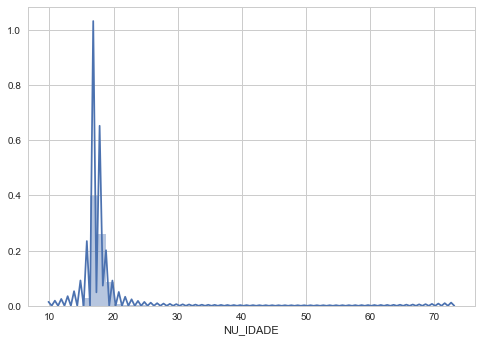

In [17]:
sns.distplot(df_modelo_trabalhado['NU_IDADE'])

#### 2. Modelo de árvore de decisão simples

In [18]:
for i in list(df_modelo_trabalhado):
    print(i + ': ' + str(type(df_modelo_trabalhado.iloc[0][i])))

level_0: <class 'numpy.int64'>
index: <class 'numpy.int64'>
NU_INSCRICAO: <class 'str'>
NU_IDADE: <class 'numpy.int64'>
TP_SEXO: <class 'str'>
TP_ESTADO_CIVIL: <class 'str'>
TP_COR_RACA: <class 'str'>
TP_ST_CONCLUSAO: <class 'str'>
TP_ENSINO: <class 'str'>
CO_MUNICIPIO_RESIDENCIA: <class 'str'>
CO_MUNICIPIO_ESC: <class 'str'>
SG_UF_ESC_x: <class 'str'>
TP_DEPENDENCIA_ADM_ESC_x: <class 'str'>
TP_LOCALIZACAO_ESC_x: <class 'str'>
IN_BAIXA_VISAO: <class 'str'>
IN_CEGUEIRA: <class 'str'>
IN_SURDEZ: <class 'str'>
IN_DEFICIENCIA_AUDITIVA: <class 'str'>
IN_SURDO_CEGUEIRA: <class 'str'>
IN_DEFICIENCIA_FISICA: <class 'str'>
IN_DEFICIENCIA_MENTAL: <class 'str'>
IN_DEFICIT_ATENCAO: <class 'str'>
IN_DISLEXIA: <class 'str'>
IN_DISCALCULIA: <class 'str'>
IN_AUTISMO: <class 'str'>
IN_VISAO_MONOCULAR: <class 'str'>
IN_OUTRA_DEF: <class 'str'>
CO_MUNICIPIO_PROVA: <class 'str'>
Q001: <class 'str'>
Q002: <class 'str'>
Q003: <class 'str'>
Q004: <class 'str'>
Q005: <class 'str'>
Q007: <class 'str'>
Q008: <c

In [19]:
# Selecionando variáveis para o modelo de árvore simplificado
variaveis_analisadas = ['NU_IDADE',
                        'renda_per_capita',
                        'IN_AGUA_REDE_PUBLICA',
                        'IN_AGUA_INEXISTENTE',
                        'IN_ENERGIA_REDE_PUBLICA',
                        'IN_ENERGIA_INEXISTENTE',
                        'IN_ESGOTO_REDE_PUBLICA',
                        'IN_ESGOTO_INEXISTENTE',
                        'IN_LIXO_COLETA_PERIODICA',
                        'IN_SALA_DIRETORIA',
                        'IN_SALA_PROFESSOR',
                        'IN_LABORATORIO_INFORMATICA',
                        'IN_LABORATORIO_CIENCIAS',
                        'IN_QUADRA_ESPORTES_COBERTA',
                        'IN_QUADRA_ESPORTES_DESCOBERTA',
                        'IN_COZINHA',
                        'IN_BIBLIOTECA',
                        'IN_SALA_LEITURA',
                        'IN_PARQUE_INFANTIL',
                        'IN_BANHEIRO_DENTRO_PREDIO',
                        'IN_REFEITORIO',
                        'IN_DESPENSA',
                        'IN_ALMOXARIFADO',
                        'IN_AUDITORIO',
                        'IN_PATIO_COBERTO',
                        'IN_INTERNET',
                        'IN_BANDA_LARGA',
                        'renda_per_capita_media_classe_quartil',
                        'in_qualif_docente_media_classe_quartil',
                        'NU_COMP_ALUNO_por_aluno_classe_quartil',
                        'NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil',
                        'NU_FUNCIONARIOS_por_aluno_classe_quartil',
                        'percentual_de_salas_utilizadas_classe_quartil',
                        'num_alunos_por_SALA_classe_quartil',
                        'in_mun_res_mesmo_esc',
                        'in_mun_esc_mesmo_prv',
                        'categoria_idade_menor_que_18',
                        'categoria_idade_18_19',
                        'categoria_idade_maior_que_19',
                        'TP_SEXO_M',
                        'TP_SEXO_F',
                        'TP_ESTADO_CIVIL_1',
                        'TP_ESTADO_CIVIL_0',
                        'TP_ESTADO_CIVIL_2',
                        'TP_ESTADO_CIVIL_3',
                        'TP_COR_RACA_1',
                        'TP_COR_RACA_0',
                        'TP_COR_RACA_4',
                        'TP_COR_RACA_2',
                        'TP_COR_RACA_5',
                        'TP_COR_RACA_3',
                        'SG_UF_ESC_x_BA',
                        'SG_UF_ESC_x_RR',
                        'SG_UF_ESC_x_GO',
                        'SG_UF_ESC_x_RO',
                        'SG_UF_ESC_x_TO',
                        'SG_UF_ESC_x_RS',
                        'SG_UF_ESC_x_PE',
                        'SG_UF_ESC_x_MS',
                        'SG_UF_ESC_x_MA',
                        'SG_UF_ESC_x_SC',
                        'SG_UF_ESC_x_PI',
                        'SG_UF_ESC_x_AM',
                        'SG_UF_ESC_x_CE',
                        'SG_UF_ESC_x_PR',
                        'SG_UF_ESC_x_DF',
                        'SG_UF_ESC_x_ES',
                        'SG_UF_ESC_x_SP',
                        'SG_UF_ESC_x_AP',
                        'SG_UF_ESC_x_RN',
                        'SG_UF_ESC_x_RJ',
                        'SG_UF_ESC_x_AL',
                        'SG_UF_ESC_x_MG',
                        'SG_UF_ESC_x_AC',
                        'SG_UF_ESC_x_PB',
                        'SG_UF_ESC_x_MT',
                        'SG_UF_ESC_x_PA',
                        'SG_UF_ESC_x_SE',
                        'TP_DEPENDENCIA_ADM_ESC_x_1',
                        'TP_DEPENDENCIA_ADM_ESC_x_3',
                        'TP_DEPENDENCIA_ADM_ESC_x_4',
                        'TP_DEPENDENCIA_ADM_ESC_x_2',
                        'ind_esc_pub_e_m',
                        'TP_LOCALIZACAO_ESC_x_1',
                        'TP_LOCALIZACAO_ESC_x_2',
                        'Q001_B',
                        'Q001_C',
                        'Q001_F',
                        'Q001_D',
                        'Q001_E',
                        'Q001_A',
                        'Q001_G',
                        'Q001_H',
                        'Q002_B',
                        'Q002_C',
                        'Q002_D',
                        'Q002_F',
                        'Q002_E',
                        'Q002_A',
                        'Q002_G',
                        'Q002_H',
                        'Q003_B',
                        'Q003_C',
                        'Q003_D',
                        'Q003_F',
                        'Q003_E',
                        'Q003_A',
                        'Q004_B',
                        'Q004_C',
                        'Q004_F',
                        'Q004_D',
                        'Q004_E',
                        'Q004_A',
                        'categoria_num_pessoas_domicilio_maior_que_5',
                        'categoria_num_pessoas_domicilio_3_a_5',
                        'categoria_num_pessoas_domicilio_ate_3',
                        'Q007_A',
                        'Q007_D',
                        'Q007_B',
                        'Q007_C',
                        'Q008_B',
                        'Q008_C',
                        'Q008_D',
                        'Q008_E',
                        'Q008_A',
                        'Q009_B',
                        'Q009_C',
                        'Q009_D',
                        'Q009_E',
                        'Q009_A',
                        'Q010_B',
                        'Q010_C',
                        'Q010_D',
                        'Q010_E',
                        'Q010_A',
                        'Q011_B',
                        'Q011_C',
                        'Q011_D',
                        'Q011_E',
                        'Q011_A',
                        'Q012_B',
                        'Q012_C',
                        'Q012_D',
                        'Q012_E',
                        'Q012_A',
                        'Q013_B',
                        'Q013_C',
                        'Q013_D',
                        'Q013_E',
                        'Q013_A',
                        'Q014_B',
                        'Q014_C',
                        'Q014_D',
                        'Q014_E',
                        'Q014_A',
                        'Q015_B',
                        'Q015_C',
                        'Q015_D',
                        'Q015_E',
                        'Q015_A',
                        'Q016_B',
                        'Q016_C',
                        'Q016_D',
                        'Q016_E',
                        'Q016_A',
                        'Q017_B',
                        'Q017_C',
                        'Q017_D',
                        'Q017_E',
                        'Q017_A',
                        'Q018_A',
                        'Q018_B',
                        'Q019_B',
                        'Q019_C',
                        'Q019_D',
                        'Q019_E',
                        'Q019_A',
                        'Q020_A',
                        'Q020_B',
                        'Q021_A',
                        'Q021_B',
                        'Q022_B',
                        'Q022_C',
                        'Q022_D',
                        'Q022_E',
                        'Q022_A',
                        'Q023_A',
                        'Q023_B',
                        'Q024_B',
                        'Q024_C',
                        'Q024_D',
                        'Q024_E',
                        'Q024_A',
                        'Q025_A',
                        'Q025_B',
                        'Q026_B',
                        'Q026_C',
                        'Q026_D',
                        'Q026_A']



In [20]:
len(variaveis_analisadas)

199

In [21]:
# Calculando correlações n x n (mostrando os pares com correlação mais significativa)
lista_correlacionadas = []
for i in variaveis_analisadas:
    for j in variaveis_analisadas:
        if np.abs(np.corrcoef(df_modelo_trabalhado[i], df_modelo_trabalhado[j])[0][1]) > 0.5:
            lista_correlacionadas.append([np.corrcoef(df_modelo_trabalhado[i], df_modelo_trabalhado[j])[0][1], i, j, np.corrcoef(df_modelo_trabalhado[i], df_modelo_trabalhado['media_geral_aluno'])[0][1], np.corrcoef(df_modelo_trabalhado[j], df_modelo_trabalhado['media_geral_aluno'])[0][1]])

In [22]:
print(len([k for k in lista_correlacionadas if k[1] != k[2]])/(len(variaveis_analisadas)**2))
print(len([k for k in lista_correlacionadas if k[1] != k[2]]))
[k for k in lista_correlacionadas if k[1] != k[2]]

0.003131234059745966
124


[[0.63249362447693469,
  'NU_IDADE',
  'categoria_idade_maior_que_19',
  -0.20213605211632898,
  -0.18897368291256955],
 [0.52514778740717616,
  'renda_per_capita',
  'renda_per_capita_media_classe_quartil',
  0.39095049532718962,
  0.44574299425748687],
 [0.52012421452173419,
  'renda_per_capita',
  'TP_DEPENDENCIA_ADM_ESC_x_4',
  0.39095049532718962,
  0.42102119992226544],
 [-0.50041391747181352,
  'renda_per_capita',
  'TP_DEPENDENCIA_ADM_ESC_x_2',
  0.39095049532718962,
  -0.45699651180275652],
 [-0.50545823480852436,
  'renda_per_capita',
  'ind_esc_pub_e_m',
  0.39095049532718962,
  -0.45962225932908124],
 [0.51413656553753739,
  'renda_per_capita',
  'Q003_E',
  0.39095049532718962,
  0.24356880867121497],
 [0.57209341783191003,
  'IN_AGUA_INEXISTENTE',
  'IN_ENERGIA_INEXISTENTE',
  -0.017945697301661824,
  -0.008127165012885202],
 [-0.51468704628893136,
  'IN_ENERGIA_REDE_PUBLICA',
  'IN_ENERGIA_INEXISTENTE',
  -0.023150764967856813,
  -0.008127165012885202],
 [0.5720934178319

In [23]:
# Retirando variáveis dentre as supercorrelacionadas
variaveis_retirar = ['categoria_idade_maior_que_19',
                     'renda_per_capita_media_classe_quartil',
                     'IN_ENERGIA_INEXISTENTE',
                     'categoria_idade_18_19',
                     'TP_SEXO_M',
                     'TP_ESTADO_CIVIL_1',
                     'TP_DEPENDENCIA_ADM_ESC_x_2',
                     'TP_DEPENDENCIA_ADM_ESC_x_3',
                     'TP_LOCALIZACAO_ESC_x_2',
                     'Q007_B',
                     'Q007_C',
                     'Q007_D',
                     'Q008_B',
                     'Q008_C',
                     'Q008_D',
                     'Q008_E',
                     'Q009_B',
                     'Q009_C',
                     'Q009_D',
                     'Q009_E',
                     'Q010_B',
                     'Q010_C',
                     'Q010_D',
                     'Q010_E',
                     'Q011_B',
                     'Q011_C',
                     'Q011_D',
                     'Q011_E',
                     'Q012_B',
                     'Q012_C',
                     'Q012_D',
                     'Q012_E',
                     'Q013_B',
                     'Q013_C',
                     'Q013_D',
                     'Q013_E',
                     'Q014_B',
                     'Q014_C',
                     'Q014_D',
                     'Q014_E',
                     'Q015_B',
                     'Q015_C',
                     'Q015_D',
                     'Q015_E',
                     'Q016_B',
                     'Q016_C',
                     'Q016_D',
                     'Q016_E',
                     'Q017_B',
                     'Q017_C',
                     'Q017_D',
                     'Q017_E',
                     'Q018_B',
                     'Q019_B',
                     'Q019_C',
                     'Q019_D',
                     'Q019_E',
                     'Q020_B',
                     'Q021_B',
                     'Q023_B',
                     'Q024_B',
                     'Q024_C',
                     'Q024_D',
                     'Q024_E',
                     'Q025_B'  
                     ]


variaveis_analisadas_final = [k for k in variaveis_analisadas if k not in variaveis_retirar]

In [24]:
print(len(variaveis_analisadas_final))
print(len(variaveis_retirar))
print(len(variaveis_analisadas))


134
65
199


In [26]:
dict_correlacoes = {'variavel': [], 'correlacao': []}
for i in variaveis_analisadas_final:
    print(i)
    dict_correlacoes['variavel'].append(i)
    dict_correlacoes['correlacao'].append(np.corrcoef(df_modelo_trabalhado[i], df_modelo_trabalhado['media_geral_aluno'])[0][1])

NU_IDADE
renda_per_capita
IN_AGUA_REDE_PUBLICA
IN_AGUA_INEXISTENTE
IN_ENERGIA_REDE_PUBLICA
IN_ESGOTO_REDE_PUBLICA
IN_ESGOTO_INEXISTENTE
IN_LIXO_COLETA_PERIODICA
IN_SALA_DIRETORIA
IN_SALA_PROFESSOR
IN_LABORATORIO_INFORMATICA
IN_LABORATORIO_CIENCIAS
IN_QUADRA_ESPORTES_COBERTA
IN_QUADRA_ESPORTES_DESCOBERTA
IN_COZINHA
IN_BIBLIOTECA
IN_SALA_LEITURA
IN_PARQUE_INFANTIL
IN_BANHEIRO_DENTRO_PREDIO
IN_REFEITORIO
IN_DESPENSA
IN_ALMOXARIFADO
IN_AUDITORIO
IN_PATIO_COBERTO
IN_INTERNET
IN_BANDA_LARGA
in_qualif_docente_media_classe_quartil
NU_COMP_ALUNO_por_aluno_classe_quartil
NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil
NU_FUNCIONARIOS_por_aluno_classe_quartil
percentual_de_salas_utilizadas_classe_quartil
num_alunos_por_SALA_classe_quartil
in_mun_res_mesmo_esc
in_mun_esc_mesmo_prv
categoria_idade_menor_que_18
TP_SEXO_F
TP_ESTADO_CIVIL_0
TP_ESTADO_CIVIL_2
TP_ESTADO_CIVIL_3
TP_COR_RACA_1
TP_COR_RACA_0
TP_COR_RACA_4
TP_COR_RACA_2
TP_COR_RACA_5
TP_COR_RACA_3
SG_UF_ESC_x_BA
SG_UF_ESC_x_RR
SG_UF_ESC_x_GO
S

In [30]:
df_correlacoes = pd.DataFrame.from_dict(dict_correlacoes)
df_correlacoes.sort_values("correlacao")

,correlacao,variavel
74,-0.459622,ind_esc_pub_e_m
128,-0.314965,Q024_A
110,-0.278899,Q010_A
129,-0.272658,Q025_A
127,-0.249060,Q023_A
118,-0.242824,Q018_A
116,-0.229466,Q016_A
121,-0.224354,Q021_A
113,-0.223759,Q013_A
107,-0.217448,Q007_A


In [31]:
# Selecionando variáveis com maiores correlações em módulo
mais_correlacionadas = list(df_correlacoes.sort_values("correlacao")["variavel"])[0:15] + list(df_correlacoes.sort_values("correlacao")["variavel"])[-15:]

In [32]:
mais_correlacionadas

['ind_esc_pub_e_m',
 'Q024_A',
 'Q010_A',
 'Q025_A',
 'Q023_A',
 'Q018_A',
 'Q016_A',
 'Q021_A',
 'Q013_A',
 'Q007_A',
 'Q014_A',
 'NU_IDADE',
 'Q003_A',
 'Q004_A',
 'Q022_B',
 'Q002_F',
 'categoria_idade_menor_que_18',
 'Q001_F',
 'Q004_E',
 'Q001_G',
 'Q002_G',
 'Q003_D',
 'Q004_D',
 'Q003_E',
 'num_alunos_por_SALA_classe_quartil',
 'IN_PARQUE_INFANTIL',
 'NU_FUNCIONARIOS_por_aluno_classe_quartil',
 'NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil',
 'renda_per_capita',
 'TP_DEPENDENCIA_ADM_ESC_x_4']

In [33]:
X = df_modelo_trabalhado[mais_correlacionadas]
y = df_modelo_trabalhado.media_geral_aluno

In [34]:
X.head()

,ind_esc_pub_e_m,Q024_A,Q010_A,Q025_A,Q023_A,Q018_A,Q016_A,Q021_A,Q013_A,Q007_A,...,Q002_G,Q003_D,Q004_D,Q003_E,num_alunos_por_SALA_classe_quartil,IN_PARQUE_INFANTIL,NU_FUNCIONARIOS_por_aluno_classe_quartil,NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil,renda_per_capita,TP_DEPENDENCIA_ADM_ESC_x_4
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0.75,1.0,0.75,1.0,2342.501667,1
1,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0.75,1.0,0.75,1.0,780.836667,1
2,0,0,1,0,1,1,1,1,1,1,...,0,1,0,0,0.75,1.0,0.75,1.0,937.003333,1
3,0,0,1,0,1,0,1,0,1,1,...,1,0,0,1,0.75,1.0,0.75,1.0,2498.670000,1
4,0,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0.75,1.0,0.75,1.0,0.000000,1


In [35]:
modelo_arvore4 = DecisionTreeRegressor(max_depth=10, max_features=10, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes=40)
train_X,val_X,train_y,val_y=train_test_split(X, y, test_size=0.1, random_state=0)
modelo_arvore4.fit(train_X,train_y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=10,
           max_leaf_nodes=40, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [57]:
modelo_arvore4.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=10,
           max_leaf_nodes=40, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>

In [36]:
val_predicoes = modelo_arvore4.predict(val_X)
print(mean_absolute_error(val_y,val_predicoes))

59.8559591304


In [46]:
def modulo(x):
    y = np.abs(x)
    return y

df_predicoes_arvore_4 = pd.DataFrame({'Actual':val_y, 'Predicted':val_predicoes})
df_predicoes_arvore_4["diferenca"] = df_predicoes_arvore_4["Actual"] - df_predicoes_arvore_4["Predicted"]
df_predicoes_arvore_4["mod_diferenca"] = df_predicoes_arvore_4["diferenca"].map(modulo)
df_predicoes_arvore_4["dif_perc_real"] = df_predicoes_arvore_4["mod_diferenca"]/df_predicoes_arvore_4["Actual"]
print(1- df_predicoes_arvore_4[df_predicoes_arvore_4["Actual"] != 0]["dif_perc_real"].mean())
df_predicoes_arvore_4

0.858756096159211


,Actual,Predicted,diferenca,mod_diferenca,dif_perc_real
425708,585.78,525.499497,60.280503,60.280503,0.102906
484325,661.82,527.111308,134.708692,134.708692,0.203543
1022224,671.38,596.700626,74.679374,74.679374,0.111233
579672,449.28,525.499497,-76.219497,76.219497,0.169648
661796,480.46,479.276969,1.183031,1.183031,0.002462
148120,481.50,499.458710,-17.958710,17.958710,0.037297
240138,685.50,641.276732,44.223268,44.223268,0.064512
1084872,495.98,517.010455,-21.030455,21.030455,0.042402
214943,449.18,456.418485,-7.238485,7.238485,0.016115
284046,608.12,516.574675,91.545325,91.545325,0.150538


In [47]:
train_predicoes = modelo_arvore4.predict(train_X)
print(mean_absolute_error(train_y,train_predicoes))

59.7137828054


In [48]:
# Exportando pdf da árvore
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import subprocess

dot_data = StringIO()
export_graphviz(modelo_arvore4, out_file='tree4.dot',  
                filled=True, rounded=True,
                special_characters=True)
subprocess.call(['dot', '-Tpdf', 'tree4.dot', '-o' 'tree4.pdf'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_jpg())

0

In [49]:
round(639.50682560664734, 8)

639.50682561

In [50]:
# Identificando quartis da distribuição dos valores reais em relação aos previstos
dict_itens = {}
lista_itens = list(set(df_predicoes_arvore_4['Predicted']))
for item in lista_itens:
    df_item = df_predicoes_arvore_4[df_predicoes_arvore_4['Predicted'] == item]
    item_min = df_item['Actual'].describe()[3]
    item_1q = df_item['Actual'].describe()[4]
    item_2q = df_item['Actual'].describe()[5]
    item_3q = df_item['Actual'].describe()[6]
    item_max = df_item['Actual'].describe()[7]
    item_1q_med = df_item[df_item['Actual'] >= item_min][df_item[df_item['Actual'] >= item_min]['Actual'] < item_1q]['Actual'].median()
    item_2q_med = df_item[df_item['Actual'] >= item_1q][df_item[df_item['Actual'] >= item_min]['Actual'] < item_2q]['Actual'].median()
    item_3q_med = df_item[df_item['Actual'] >= item_2q][df_item[df_item['Actual'] >= item_min]['Actual'] < item_3q]['Actual'].median()
    item_4q_med = df_item[df_item['Actual'] >= item_3q][df_item[df_item['Actual'] >= item_min]['Actual'] < item_max]['Actual'].median()

    dict_itens[round(item,8)] = [item_1q_med, item_2q_med, item_3q_med, item_4q_med]

print(dict_itens)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


{641.27673163999998: [540.38, 624.06, 673.49, 727.5200000000001], 516.57467515999997: [435.46000000000004, 498.14, 541.94, 599.0600000000001], 517.01045523000005: [441.2, 502.73999999999995, 545.04, 600.24], 523.08916180000006: [440.2, 508.91999999999996, 550.9200000000001, 605.3499999999999], 525.49949729000002: [447.6, 512.5799999999999, 556.74, 610.72], 527.11130793999996: [451.58000000000004, 510.54, 552.5200000000001, 607.3199999999999], 534.90021823999996: [461.53000000000003, 512.49, 555.29, 614.5600000000001], 540.44152155999996: [451.4, 517.82, 568.75, 631.29], 423.12715790999999: [331.64, 419.03999999999996, 457.81, 502.64], 560.50749273999998: [480.45000000000005, 544.5, 590.12, 643.3799999999999], 560.01308187999996: [483.40999999999997, 540.0, 586.2, 642.8], 563.73081757: [487.01, 550.4399999999999, 594.9499999999999, 658.0200000000001], 436.19262837000002: [337.49, 432.6500000000001, 470.5, 519.9], 566.91668786000002: [488.97, 549.08, 593.72, 650.55], 442.58399505: [337.2

### 3. Criando cadeia "if else" representando a árvore.

In [51]:
from sklearn.tree import _tree
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [52]:
tree_to_code(modelo_arvore4,list(X.columns))

def tree(ind_esc_pub_e_m, Q024_A, Q010_A, Q025_A, Q023_A, Q018_A, Q016_A, Q021_A, Q013_A, Q007_A, Q014_A, NU_IDADE, Q003_A, Q004_A, Q022_B, Q002_F, categoria_idade_menor_que_18, Q001_F, Q004_E, Q001_G, Q002_G, Q003_D, Q004_D, Q003_E, num_alunos_por_SALA_classe_quartil, IN_PARQUE_INFANTIL, NU_FUNCIONARIOS_por_aluno_classe_quartil, NU_EQUIP_MULTIMIDIA_por_aluno_classe_quartil, renda_per_capita, TP_DEPENDENCIA_ADM_ESC_x_4):
  if renda_per_capita <= 562.2015380859375:
    if ind_esc_pub_e_m <= 0.5:
      if renda_per_capita <= 240.41598510742188:
        if NU_IDADE <= 18.5:
          if Q024_A <= 0.5:
            return [[ 560.01308188]]
          else:  # if Q024_A > 0.5
            return [[ 534.90021824]]
        else:  # if NU_IDADE > 18.5
          if TP_DEPENDENCIA_ADM_ESC_x_4 <= 0.5:
            return [[ 540.44152156]]
          else:  # if TP_DEPENDENCIA_ADM_ESC_x_4 > 0.5
            return [[ 489.42353712]]
      else:  # if renda_per_capita > 240.41598510742188
        return [

In [46]:
modelo_arvore4

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=20,
           max_leaf_nodes=40, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')